<a href="https://colab.research.google.com/github/NanaAkwasiAbayieBoateng/NLP/blob/main/XLNET_Finetuning_Kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Introduction

XLNet is a  generalized autoregressive Transformer that enables
learning bidirectional contexts by maximizing the expected likelihood  of a sequence w.r.t. all possible permutations of the factorization order. XLNet employs Transformer-XL autoregressive model into pretraining but without the limitation of the fixed forward or backward factorization order of autoregressive models. XLNet achieves state-of-the-art results on various natural language task that involves long text sequence in question answering, sentiment analysis, natural language inference and document ranking. The permutation operation enables the  context for each position to  consist of tokens from both left and right. The birectional context in a sequence  is captured by the expectation where each position learns to utilize contextual information  from all psitions.

 The technical details is available in the paper [XLNet: Generalized Autoregressive Pretraining for Language Understanding](https://arxiv.org/abs/1906.08237v2)




In [3]:
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In order for torch to use the GPU, we need to identify and specify the GPU as the device. Later, in our training loop, we will load data onto the device.

In [4]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


Next, let's install the transformers package from Hugging Face which will give us a pytorch interface for working with XLNet. This package strikes a nice balance between the high-level APIs (which are easy to use but don't provide insight into how things work) and tensorflow code (which contains lots of unnecessary details).

In [6]:
#!pip install transformers=='2.8.0'
!pip install transformers
!pip install sentencepiece

In [40]:
!pip install transformers==2.9.0 
!pip install pytorch_lightning==0.7.5

     |████████████████████████████████| 645kB 14.1MB/s 
     |████████████████████████████████| 5.6MB 30.1MB/s 
  Found existing installation: tokenizers 0.10.2
    Uninstalling tokenizers-0.10.2:
      Successfully uninstalled tokenizers-0.10.2
  Found existing installation: transformers 4.5.1
    Uninstalling transformers-4.5.1:
      Successfully uninstalled transformers-4.5.1


     |████████████████████████████████| 235kB 19.5MB/s 
     |████████████████████████████████| 829kB 51.3MB/s 
  Created wheel for future: filename=future-0.18.2-cp37-none-any.whl size=491058 sha256=a4af758272e984c76fa161aa7795d067c3d78c40178b10fd9a11d24986ead32d
  Stored in directory: /root/.cache/pip/wheels/8b/99/a0/81daf51dcd359a9377b110a8a886b3895921802d2fc1b2397e
Successfully built future
  Found existing installation: future 0.16.0
    Uninstalling future-0.16.0:
      Successfully uninstalled future-0.16.0


####  Load Data

The dataset for this exercise is from kaggle and located [here](https://www.kaggle.com/clmentbisaillon/fake-and-real-news-dataset).




In [7]:
import pandas as pd
import re
import os
import math
import torch
# import torch.nn as nn
from torch.nn import BCEWithLogitsLoss, NLLLoss
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
# from pytorch_transformers import XLNetModel, XLNetTokenizer, XLNetForSequenceClassification
from transformers import AdamW, XLNetTokenizer, XLNetModel, TFXLNetModel, XLNetLMHeadModel, XLNetConfig, XLNetForSequenceClassification
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import numpy as np
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
import unicodedata
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix,roc_auc_score
import seaborn as sns
import itertools
import plotly
import seaborn as sns
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
from collections import Counter  
%matplotlib inline


In [9]:
from zipfile import ZipFile

#!unzip /content/drive/MyDrive/Data/Fake_True_News.zip
zip_file = ZipFile('/content/drive/MyDrive/Data/Fake_True_News.zip')
zip_file
zip_file.infolist()

[<ZipInfo filename='Fake.csv' compress_type=deflate file_size=62789876 compress_size=23982401>,
 <ZipInfo filename='True.csv' compress_type=deflate file_size=53582940 compress_size=18993224>]

In [10]:
import pandas as pd
from zipfile import ZipFile


True_data = pd.read_csv(zip_file.open('True.csv'),encoding='UTF-8')
True_data['label']= 1
True_data.head()

,title,text,subject,date,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1


In [12]:
Fake_data = pd.read_csv(zip_file.open('Fake.csv'),encoding='UTF-8')
Fake_data['label']=0
Fake_data.head()

,title,text,subject,date,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0


In [14]:
data= pd.concat([True_data,Fake_data],axis=0)

from sklearn.utils import shuffle
data = shuffle(data)
print("number of rows of data {}".format(data.shape[0]))
data.head()


number of rows of data 44898


,title,text,subject,date,label
3409,Trump administration moves to keep full CIA 't...,WASHINGTON (Reuters) - U.S. President Donald T...,politicsNews,"June 2, 2017",1
19642,AFTER 8 Years Of Silence From Obama On Cop Kil...,Here s just one of many discussions of assassi...,left-news,"Nov 11, 2016",0
14906,"Russia, U.S. stalemate over Syria chemical wea...",UNITED NATIONS (Reuters) - Russia said on Mond...,worldnews,"November 14, 2017",1
11211,Trump fans in Iowa cheer his debate performance,"WAUKEE, Iowa (Reuters) - It was not hard to te...",politicsNews,"January 15, 2016",1
14858,NEW YORK OFFICIALS Confirm Donald Trump’s Clai...,The media really wants to bury Trump on this b...,politics,"Dec 2, 2015",0


In [16]:
temp = data['label'].value_counts()
#temp = pd.DataFrame(temp,columns=['label','counts'])
temp = pd.DataFrame(temp).reset_index()
temp.columns=['label','counts']


In [17]:
cm = sns.light_palette("green", as_cmap=True)
temp.style.background_gradient(cmap=cm)
#fig = px.scatter(temp, x="day", y="Counts",mode='lines+markers')
fig = go.Figure()
#fig.add_trace(go.bar(x=temp.day, y=temp.Counts ))
#fig = px.line(temp, x="day", y="Counts")
fig = px.bar(temp, x="label", y="counts",color="counts")
fig.update_layout(
    title=" Frequency of Words Used In News per Month of the Year",
    xaxis_title="Label",
    yaxis_title="Frequency",
    #legend_title="",
    font=dict(
        family="Courier New, monospace",
        size=18,
        color="white"
    )
)

fig.update_xaxes(showline=True, linewidth=2, linecolor='black', mirror=True)
fig.update_yaxes(showline=True, linewidth=2, linecolor='black', mirror=True)
fig.update_layout( template="plotly_dark")
fig.show()
fig.write_html("/content/drive/MyDrive/Colab Notebooks/NLP/XLNET/file1.html")

We split the data into train and test, the training will later tbe split again into training and validation sets. The test set would be used for testing the model performance later on.

In [18]:
train ,test = train_test_split(data, random_state=2018, test_size=0.2)

print('Number of training sentences: {:,}\n'.format(train.shape[0]))
print('Number of testing sentences: {:,}\n'.format(test.shape[0]))

Number of training sentences: 35,918

Number of testing sentences: 8,980



#### Pre-processing Tweets
Preprocessing is done in general to clean up the text data before modeling. Some usual actions taken to clean up the text include removing unwanted characters, stripping of spaces and tekenizing the text data.

In [19]:
from nltk.tokenize import WordPunctTokenizer
import re
# import emoji
from bs4 import BeautifulSoup
import itertools

tok = WordPunctTokenizer()
pat1 = r'@[A-Za-z0-9]+'
pat2 = r'https?://[A-Za-z0-9./]+'


# Converts the unicode file to ascii
def unicode_to_ascii(s):
  return ''.join(c for c in unicodedata.normalize('NFD', s)
      if unicodedata.category(c) != 'Mn')



def preprocess_sentence_english(w):
  w = unicode_to_ascii(w.lower().strip())

  # creating a space between a word and the punctuation following it
  # eg: "he is a boy." => "he is a boy ."
  # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
  w = re.sub(r"([?.!,¿])", r" \1 ", w)
  w = re.sub(r'[" "]+', " ", w)

  # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
  w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)
  #w = re.sub(r'[^Ɔ-ɔɛƐ]+', r' ', w)
  #strip() Parameters
  #chars (optional) - a string specifying the set of characters to be removed.
  #If the chars argument is not provided, all leading and trailing whitespaces are removed from the string.
  w = w.rstrip().strip()

 
  # Fix misspelled words
  w = ''.join(''.join(s)[:2] for _, s in itertools.groupby(w))# checking that each character should occur not more than 2 times in every word

  # Tokenizing ,change cases & join together to remove unneccessary white spaces
  w = tok.tokenize(w)
  w = (" ".join(w)).strip()
  return w

#### Checking the distribution of token lengths
The distribution of the token lengths 

In [20]:
from transformers import XLNetTokenizer, XLNetLMHeadModel
import torch

tokenizer = XLNetTokenizer.from_pretrained('xlnet-large-cased')
model = XLNetLMHeadModel.from_pretrained('xlnet-large-cased')

# We show how to setup inputs to predict a next token using a bi-directional context.
input_ids = torch.tensor(tokenizer.encode("Hello, my dog is very <mask>", add_special_tokens=False)).unsqueeze(0)  # We will predict the masked token
perm_mask = torch.zeros((1, input_ids.shape[1], input_ids.shape[1]), dtype=torch.float)
perm_mask[:, :, -1] = 1.0  # Previous tokens don't see last token
target_mapping = torch.zeros((1, 1, input_ids.shape[1]), dtype=torch.float)  # Shape [1, 1, seq_length] => let's predict one token
target_mapping[0, 0, -1] = 1.0  # Our first (and only) prediction will be the last token of the sequence (the masked token)


In [21]:
from transformers import XLNetTokenizer, XLNetModel
PRE_TRAINED_MODEL_NAME = 'xlnet-base-cased'
tokenizer = XLNetTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME, do_lower_case=True)

token_lens = []

for txt in data['text']:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))


data["token_length"]  = token_lens


In [16]:
import plotly.figure_factory as ff
import numpy as np


# Group data together
hist_data = [data[data.label==0]["token_length"], data[data.label==1]["token_length"]]

group_labels = ['Fake', 'Real']
colors = ['slategray', 'magenta']
                         
# Create distplot with custom bin_size
fig = ff.create_distplot(hist_data, group_labels, bin_size=.2,
                          curve_type='normal', # override default 'kde'
                         colors=colors)
#fig = ff.create_distplot(hist_data, group_labels, show_hist=False, colors=colors)
# Add title
#fig.update_layout(title_text='Distribution of Text Token Counts')
fig.update_xaxes(showline=True, linewidth=2, linecolor='black', mirror=True)
fig.update_yaxes(showline=True, linewidth=2, linecolor='black', mirror=True)
fig.update_layout(xaxis_range=[0,600])
fig.update_layout(yaxis_range=[0,0.04])
fig.update_layout( template="plotly")
fig.update_layout(
    autosize=False,
    width=1000,
    height=600,)
fig.update_layout(
    title=" Distribution of Text Token Length",
    xaxis_title="Token Length",
    yaxis_title="Frequency")
fig.show()
fig.write_html("/content/drive/MyDrive/Colab Notebooks/NLP/XLNET/file2.html")

In [22]:
# cleaning tweets
train['text_cleaned'] = list(map(lambda x: preprocess_sentence_english(x),train['text']) )
test['text_cleaned'] = list(map(lambda x: preprocess_sentence_english(x),test['text']) )

In [23]:
train.head()

,title,text,subject,date,label,text_cleaned
14999,CNBC DEBATE HACK Proves Allegiance To Democrat...,By looking at the two Democrat presidential ca...,politics,"Oct 31, 2015",0,by looking at the two democrat presidential ca...
18345,Putin: Russia-U.S. ties may improve through jo...,MOSCOW (Reuters) - President Vladimir Putin sa...,worldnews,"October 4, 2017",1,moscow reuters president vladimir putin said o...
17512,"EU plans Brexit summit gesture, May hints on cash",BRUSSELS (Reuters) - Britain will be offered a...,worldnews,"October 13, 2017",1,brussels reuters britain will be offered a goo...
394,"Lower taxes, big gains: The stocks poised to w...",NEW YORK (Reuters) - A proposal driven by Pres...,politicsNews,"December 1, 2017",1,new york reuters a proposal driven by presiden...
9004,Here Are The Right-Wing Scumbags The Bundy Mi...,When the tense standoff between federal agents...,News,"January 3, 2016",0,when the tense standoff between federal agents...


The sentences and labels can be conveted yo a nummp array by using the values function.

 extract the sentences and labels of our training set as numpy ndarrays.

In [24]:
sentences = train.text_cleaned.values
labels = train.label.values
sentences[0:5]

array(['by looking at the two democrat presidential candidates left standing , most americans would think their platform is primarily about the destruction of capitalism and gun control . the real truth however , is that the democrat party knows without their unyielding support for the culture of death , they would cease to exist . the sickening truth is , they either support the killing of the most vulnerable or it s curtains for them . what does that say about how far our society has fallen when leftist tv hosts celebrate china s brutal one child policy on twitter ? quintanilla may not have been endorsing the one child policy , but he didn t offer any overt or even implied criticism of it either . in fact , saying it worked sounds a lot like he is suggesting it was a success . the problem , of course , is that the one child policy , which china converted to a two child policy this week , was a brutal , harrowing invasion of the human rights of millions of families under the guise of 

#### 3. Tokenization & Input Formatting

Before we can feed our data to XLNet, we have to transform it to a format that works with XLNet.



#### 3.1 XLNet Tokenizer
To feed our text to XLNet, it must be split into tokens, and then these tokens must be mapped to their index in the tokenizer vocabulary.


The XLNetTokenizer and the pretrained cased version of the XLNetModel from huggingface can be loaded here. The tokenizer inherits from PreTrainedTokenizer which contains most of the main methods. This model is also a PyTorch `torch.nn.Module` subclass and can be used as a regular   pytroch module. The Tensorflow equivalent is the `TFXLNetModel`.

In [26]:
from transformers import XLNetTokenizer, XLNetModel
PRE_TRAINED_MODEL_NAME = 'xlnet-base-cased'
tokenizer = XLNetTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME, do_lower_case=True)

Here, let's apply the tokenizer on a single sentence and output it together wit it's token id's to demonstrate  how the tokenizer work.

In [28]:

print(' Original sentence {}: '.format( sentences[1]))


print('Tokenized sentence {}:  '.format(tokenizer.tokenize(sentences[1])))

# Print the tweet mapped to token ids.
print('Token IDs  {}: '.format(tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[1]))))

 Original sentence moscow reuters president vladimir putin said on wednesday that ties with u . s . president donald trump s administration were not without problems , but he hoped that mutual interests of russia and the united states in fighting terrorism would help improve moscow s relations with washington . some forces are making use of russian american relations to resolve internal political problems in the united states , putin told an energy forum in moscow . i believe that such a person like trump , with his character , will never be hostage to someone s interests . moscow has lots of friends in the united states who genuinely want to improve relations with russia , putin added .: 
Tokenized sentence ['▁mo', 'sco', 'w', '▁', 're', 'uter', 's', '▁president', '▁v', 'la', 'di', 'mir', '▁put', 'in', '▁said', '▁on', '▁we', 'd', 'nes', 'day', '▁that', '▁ties', '▁with', '▁', 'u', '▁', '.', '▁', 's', '▁', '.', '▁president', '▁don', 'ald', '▁trump', '▁', 's', '▁administration', '▁were',

#### 3.2 Tokenize Dataset
XLNet model has several inputs which is fed to. Among them are the following:

* inputs_ids : Indices of input sequence tokens in the vocabulary. It is obtained by using `transformers.XLNetTokenizer` function. These are the integer id's/index of the input tokens generated by the tokenizer.

* token_type_ids : Segment token indices to indicate first and second portions of the inputs. Indices are selected in `[0, 1]`:

 * 0 corresponds to a sentence A token,

 * 1 corresponds to a sentence B token.

* attention_mask  : Mask to avoid performing attention on padding token indices. Mask values selected in `[0, 1]`.

 * 1 for tokens that are not masked
 * 0  for tokens that are masked.

* labels: a single value of 1 or 0. For our data real news is 1 and fake news is 0.

There are many more other optional inputs. For additional input functions look up [here]("https://huggingface.co/transformers/model_doc/xlnet.html#xlnetmodel).



To  format inputs arrays to be the same length as required by XLNet, we can specify a maximum sequence length then pad sequences with length less this maximum with zeros.Sequences with lengths greater than the maximum is truncated. The paading  short sequences and truncating longer sequences at the maximum length specified formats all the input arrays to the same size.











In [31]:
#def tokenize_inputs(text_list, tokenizer, num_embeddings=120):
def tokenize_inputs(text_list, tokenizer, num_embeddings=120):
    """
    Tokenizes the input text input into ids. Appends the appropriate special
    characters to the end of the text to denote end of sentence. Truncate or pad
    the appropriate sequence length.
    """
    # tokenize the text, then truncate sequence to the desired length minus 2 for
    # the 2 special characters
    tokenized_texts = list(map(lambda t: tokenizer.tokenize(t)[:num_embeddings-2], text_list))
    # convert tokenized text into numeric ids for the appropriate LM
    input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
    # append special token "<s>" and </s> to end of sentence
    input_ids = [tokenizer.build_inputs_with_special_tokens(x) for x in input_ids]
    # pad sequences
    input_ids = pad_sequences(input_ids, maxlen=num_embeddings, dtype="long", truncating="post", padding="post")
    return input_ids

def create_attn_masks(input_ids):
    """
    Create attention masks to tell model whether attention should be applied to
    the input id tokens. Do not want to perform attention on padding tokens.
    """
    # Create attention masks
    attention_masks = []

    # Create a mask of 1s for each token followed by 0s for padding
    for seq in input_ids:
        seq_mask = [float(i>0) for i in seq]
        attention_masks.append(seq_mask)
    return attention_masks

In [33]:
# Tokenize all of the sentences and map the tokens to thier word IDs.

input_ids = tokenize_inputs(sentences, tokenizer, num_embeddings=120)
attention_masks = create_attn_masks(input_ids)

# Convert the lists into tensors.
# input_ids = torch.cat(input_ids, dim=0)
# attention_masks = torch.cat(attention_masks, dim=0)
input_ids = torch.from_numpy(input_ids)
attention_masks = torch.tensor(attention_masks)
labels = torch.tensor(labels)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[1])
print('Token IDs:', input_ids[1])
print('Token IDs:', attention_masks[1])

Original:  moscow reuters president vladimir putin said on wednesday that ties with u . s . president donald trump s administration were not without problems , but he hoped that mutual interests of russia and the united states in fighting terrorism would help improve moscow s relations with washington . some forces are making use of russian american relations to resolve internal political problems in the united states , putin told an energy forum in moscow . i believe that such a person like trump , with his character , will never be hostage to someone s interests . moscow has lots of friends in the united states who genuinely want to improve relations with russia , putin added .
Token IDs: tensor([ 6353,  5993,   694,    17,    88, 12105,    23,   379,  2721,   867,
         1528,  6687,   331,   153,    42,    31,    80,    66,  4048,   765,
           29,  3278,    33,    17,   660,    17,     9,    17,    23,    17,
            9,   379,   220, 11945, 24716,    17,    23,  1048,   

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



#### 3.4. Training & Validation Split¶
Divide up our training set to use 80% for training and 20% for validation.

In [34]:
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 80-20 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Checking whether the distribution of target is consitent across both the sets
label_temp_list = []
for a,b,c in train_dataset:
  label_temp_list.append(c)

print('{:>5,} training samples'.format(train_size))
print('{:>5,} training samples with real news'.format(sum(label_temp_list)))

label_temp_list = []
for a,b,c in val_dataset:
  label_temp_list.append(c)

print('{:>5,} validation samples'.format(val_size))
print('{:>5,} validation samples with real news'.format(sum(label_temp_list)))

28,734 training samples
13,655 training samples with real news
7,184 validation samples
3,450 validation samples with real news




The PyTorch [torch.utils.data.DataLoader]("https://pytorch.org/docs/stable/data.html") class Combines a dataset and a sampler, and provides an iterable over the given dataset.

The DataLoader supports both map-style and iterable-style datasets with single- or multi-process loading, customizing loading order and optional automatic batching (collation) and memory pinning. The iterator saves memory during training since the entire dataset does not have to be loaded into memory.

In [36]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here. Batch size of 16 or 32.
batch_size = 16

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

#### 4. Fine - Tuning our  Classification Model




There are several pretrained XLNet models from hugginface namely xlnet-base-cased, xlnet-large-caseed etc. We would be use `xlnet-base-cased` which is a 12-layer, 768-hidden, 12-headsTransformel XL model with both lower and upper case in the training data used in creating the pretrained model. For comprehensive list of the various pretrained XLNet models from huggingface, check out this link [here]("https://huggingface.co/models?filter=xlnet).


Transfer learning is the process of using a pretrained model, keeping most of the layers of the model and modifiying the last layer to adapt to the data of interest. It allows us to migrate the knowledge learned from the source dataset to a target dataset. Transfer learning allows us to scale over issues such as low accuracy that results from training a model on relatively small dataset and also computational  resource constraints in training large models. It allows us to take advantage of the patterns already learned in a prevoius layers of a large model and adapt it to our dataset. Further information on fine - tuning is available in  textbook Dive into Deep Learning  which discusses Fine - Tuning in  chapter 13 section 2  [here]("https://d2l.ai/chapter_computer-vision/fine-tuning.html). In fine- tuning we assume the output layer of the source model is similar to our target label for example we use a pre-trained sequence classification model to fine- tune our dataset which is of sequence classification nature and not some other task such as question answering. The output layer has size equal to the number of classes in our target label. We train the target model on our target dataset. The output layer is trained from scratch while the parameters of all remaining layers are fine-tuned based on the parameters of the source model.
The target model replicates all model designs and their parameters on the source model, except the output layer, and fine-tunes these parameters based on the target dataset. In contrast, the output layer of the target model needs to be trained from scratch if not using transfer learning.








In [37]:

     
class XLNetForMultiLabelSequenceClassification(torch.nn.Module):
  
  def __init__(self, num_labels=2):
    super(XLNetForMultiLabelSequenceClassification, self).__init__()
    self.num_labels = num_labels
    self.xlnet = XLNetModel.from_pretrained('xlnet-base-cased')
    self.classifier = torch.nn.Linear(768, num_labels)

    torch.nn.init.xavier_normal_(self.classifier.weight)

  def forward(self, input_ids, token_type_ids=None,\
              attention_mask=None, labels=None):
       
    # last hidden layer
    last_hidden_state = self.xlnet(input_ids=input_ids,\
                                   attention_mask=attention_mask,\
                                   token_type_ids=token_type_ids
                                  )
    # pool the outputs into a mean vector
    mean_last_hidden_state = self.pool_hidden_state(last_hidden_state)
    logits = self.classifier(mean_last_hidden_state)
   
    logits = logits[:, 1] - logits[:, 0]
    if labels is not None:

      loss = BCEWithLogitsLoss()(logits, labels.float())
#      
    
      return loss
    else:
      return logits
    
  def freeze_xlnet_decoder(self):
    """
    Freeze XLNet weight parameters. They will not be updated during training.
    """
    for param in self.xlnet.parameters():
      param.requires_grad = False
    
  def unfreeze_xlnet_decoder(self):
    """
    Unfreeze XLNet weight parameters. They will be updated during training.
    """
    for param in self.xlnet.parameters():
      param.requires_grad = True
  def pool_hidden_state(self, last_hidden_state):
    """
    Pool the output vectors into a single mean vector 
    """
    last_hidden_state = last_hidden_state[0]
    mean_last_hidden_state = torch.mean(last_hidden_state, 1)
    return mean_last_hidden_state
    
model = XLNetForMultiLabelSequenceClassification(num_labels=len(labels.unique()))
   

 `AdamW` is a huggingface transformer class wrapper of `AdamW`, the Decoupled Weight Decay algorithm. An optimizer with weight decay fixed that can be used to fine-tuned models, and
several schedules in the form of schedule objects and gradient accumulation of multiple batches.

 PyTorch has similar implementation in the optim package.
`torch.optim` is a PyTorch package  that implements various optimization algorithms.
`torch.optim.AdamW` : Implements AdamW algorithm. The original Adam algorithm was proposed in Adam: A Method for Stochastic Optimization. The AdamW variant was proposed in Decoupled Weight Decay Regularization. The paper for this algorithm is found 
[here]("https://arxiv.org/abs/1711.05101").
Generally, fine tuning parameters use a smaller learning rate, while training the output layer from scratch can use a larger learning rate.

In [41]:

#optimizer = AdamW(model.parameters(),
#                  lr = 2e-5, # args.learning_rate - default is 5e-5
#                  # eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
#                 weight_decay=0.01,
#                 correct_bias=False
#                )
#

# scheduler = WarmupLinearSchedule(optimizer, warmup_steps=num_warmup_steps, t_total=num_total_steps)  # PyTorch scheduler

In [42]:

# replace AdamW with Adafactor
#optimizer = Adafactor(model.parameters(), scale_parameter=True, relative_step=True, warmup_init=True, lr=None)

#import torch  
#import torch.optim


param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
                                {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
                                {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay':0.0}
]
optimizer = AdamW(optimizer_grouped_parameters, lr=3e-5)


In [ ]:
# replace AdamW with Adafactor
#optimizer = Adafactor(
 #   model.parameters(),
  #  lr=1e-5,
   # eps=(1e-30, 1e-3),
    #clip_threshold=1.0,
    #decay_rate=-0.8,
    #beta1=None,
    #weight_decay=0.01,
    #relative_step=False,
    #scale_parameter=False,
    #warmup_init=False
#)

The training loop together with model validation is done below. The main steps invloved here is for each pass in our loop we have a training phase and a validation phase. At each pass we need to:

Training loop:

- Tell the model to compute gradients by setting the model in train mode
- Unpack our data inputs and labels
- Load data onto the GPU for acceleration
- Clear out the gradients calculated in the previous pass. In pytorch the gradients accumulate by default (useful for things like RNNs) unless you explicitly clear them out
- Forward pass (feed input data through the network)
- Backward pass (backpropagation)
- Tell the network to update parameters with optimizer.step()
- Track variables for monitoring progress
Evalution loop:

Tell the model not to compute gradients by setting th emodel in evaluation mode
- Unpack our data inputs and labels
- Load data onto the GPU for acceleration
- Forward pass (feed input data through the network)
- Compute loss on our validation data and track variables for monitoring progress

In [43]:
def train(model, num_epochs,\
          optimizer,\
          train_dataloader, valid_dataloader,\
          model_save_path,\
          train_loss_set=[], valid_loss_set = [],\
          lowest_eval_loss=None, start_epoch=0,\
          device="cpu"
          ):
  """
  Train the model and save the model with the lowest validation loss
  """
  # We'll store a number of quantities such as training and validation loss, 
  # validation accuracy, and timings.
  training_stats = []
  # Measure the total training time for the whole run.
  total_t0 = time.time()

  model.to(device)

  # trange is a tqdm wrapper around the python range function
  for i in trange(num_epochs, desc="Epoch"):
    # if continue training from saved model
    actual_epoch = start_epoch + i
   

    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set. 
    print("")
    print('======== Epoch {:} / {:} ========'.format(actual_epoch, num_epochs))
    print('Training...')
    
    # Measure how long the training epoch takes.
    t0 = time.time()
    
    # Set our model to training mode (as opposed to evaluation mode)
    model.train()

    # Tracking variables
    tr_loss = 0
    num_train_samples = 0

    # Train the data for one epoch
    for step, batch in enumerate(train_dataloader):
        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0: 
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))
            
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        # Clear out the gradients (by default they accumulate)
        optimizer.zero_grad()
        # Forward pass
        loss = model(input_ids=b_input_ids, attention_mask=b_input_mask, labels=b_labels)
        # store train loss
        tr_loss += loss.item()
        num_train_samples += b_labels.size(0)
        # Backward pass
        loss.backward()
        # Update parameters and take a step using the computed gradient
        optimizer.step()
        #scheduler.step()

    # Update tracking variables
    epoch_train_loss = tr_loss/num_train_samples
    train_loss_set.append(epoch_train_loss)

#     print("Train loss: {}".format(epoch_train_loss))
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(epoch_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
    
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.
    
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()
    
    # Put model in evaluation mode to evaluate loss on the validation set
    model.eval()

    # Tracking variables 
    eval_loss = 0
    num_eval_samples = 0

    # Evaluate data for one epoch
    for batch in valid_dataloader:
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        # Telling the model not to compute or store gradients,
        # saving memory and speeding up validation
        with torch.no_grad():
            # Forward pass, calculate validation loss
            loss = model(input_ids=b_input_ids, attention_mask=b_input_mask, labels=b_labels)
            # store valid loss
            eval_loss += loss.item()
            num_eval_samples += b_labels.size(0)

    epoch_eval_loss = eval_loss/num_eval_samples
    valid_loss_set.append(epoch_eval_loss)

#     print("Valid loss: {}".format(epoch_eval_loss))
    
    # Report the final accuracy for this validation run.
#     avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
#     print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
#     avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(epoch_eval_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': actual_epoch,
            'Training Loss': epoch_train_loss,
            'Valid. Loss': epoch_eval_loss,
#             'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

    
    if lowest_eval_loss == None:
      lowest_eval_loss = epoch_eval_loss
      # save model
      save_model(model, model_save_path, actual_epoch,\
                 lowest_eval_loss, train_loss_set, valid_loss_set)
    else:
      if epoch_eval_loss < lowest_eval_loss:
        lowest_eval_loss = epoch_eval_loss
        # save model
        save_model(model, model_save_path, actual_epoch,\
                   lowest_eval_loss, train_loss_set, valid_loss_set)
  
  print("")
  print("Training complete!")

  print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))
  return model, train_loss_set, valid_loss_set, training_stats    


In [45]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [46]:

save_path = '/content/drive/MyDrive/Colab Notebooks/NLP/HuggingFace/XLNET/'


In [47]:
# function to save and load the model form a specific epoch
def save_model(model, save_path, epochs, lowest_eval_loss, train_loss_hist, valid_loss_hist):
  """
  Save the model to the path directory provided
  """
  model_to_save = model.module if hasattr(model, 'module') else model
  checkpoint = {'epochs': epochs, \
                'lowest_eval_loss': lowest_eval_loss,\
                'state_dict': model_to_save.state_dict(),\
                'train_loss_hist': train_loss_hist,\
                'valid_loss_hist': valid_loss_hist,\
                'optimizer_state_dict': optimizer.state_dict()
               }
               
  torch.save(checkpoint, save_path)
  print("Saving model at epoch {} with validation loss of {}".format(epochs,\
                                                                     lowest_eval_loss))
  return
def load_model(save_path):
  """
  Load the model from the path directory provided
  """
  checkpoint = torch.load(save_path)
  model_state_dict = checkpoint['state_dict']
  model = XLNetForMultiLabelSequenceClassification(num_labels=model_state_dict["classifier.weight"].size()[0])
  model.load_state_dict(model_state_dict)

  epochs = checkpoint["epochs"]
  lowest_eval_loss = checkpoint["lowest_eval_loss"]
  train_loss_hist = checkpoint["train_loss_hist"]
  valid_loss_hist = checkpoint["valid_loss_hist"]
  
  return model, epochs, lowest_eval_loss, train_loss_hist, valid_loss_hist  


In [48]:
torch.cuda.empty_cache()

In [49]:
num_epochs = 5

cwd = os.getcwd()

model_save_path = output_model_file = "/content/drive/MyDrive/Colab Notebooks/NLP/XLNET/xlnet.bin"



model, train_loss_set, valid_loss_set, training_stats = train(model=model,\
                                                              num_epochs=num_epochs,\
                                                              optimizer=optimizer,\
                                                              train_dataloader=train_dataloader,\
                                                              valid_dataloader=validation_dataloader,\
                                                              model_save_path=model_save_path,\
                                                              device="cuda"
                                                              )

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]


======== Epoch 0 / 5 ========
Training...


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:155: UserWarning:

This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:1005.)



  Batch    40  of  1,796.    Elapsed: 0:00:18.
  Batch    80  of  1,796.    Elapsed: 0:00:36.
  Batch   120  of  1,796.    Elapsed: 0:00:55.
  Batch   160  of  1,796.    Elapsed: 0:01:13.
  Batch   200  of  1,796.    Elapsed: 0:01:32.
  Batch   240  of  1,796.    Elapsed: 0:01:51.
  Batch   280  of  1,796.    Elapsed: 0:02:11.
  Batch   320  of  1,796.    Elapsed: 0:02:31.
  Batch   360  of  1,796.    Elapsed: 0:02:50.
  Batch   400  of  1,796.    Elapsed: 0:03:10.
  Batch   440  of  1,796.    Elapsed: 0:03:31.
  Batch   480  of  1,796.    Elapsed: 0:03:50.
  Batch   520  of  1,796.    Elapsed: 0:04:10.
  Batch   560  of  1,796.    Elapsed: 0:04:30.
  Batch   600  of  1,796.    Elapsed: 0:04:51.
  Batch   640  of  1,796.    Elapsed: 0:05:11.
  Batch   680  of  1,796.    Elapsed: 0:05:31.
  Batch   720  of  1,796.    Elapsed: 0:05:51.
  Batch   760  of  1,796.    Elapsed: 0:06:11.
  Batch   800  of  1,796.    Elapsed: 0:06:31.
  Batch   840  of  1,796.    Elapsed: 0:06:52.
  Batch   880

Epoch:  20%|██        | 1/5 [16:41<1:06:44, 1001.08s/it]

Saving model at epoch 0 with validation loss of 0.00033740604524109483

======== Epoch 1 / 5 ========
Training...
  Batch    40  of  1,796.    Elapsed: 0:00:20.
  Batch    80  of  1,796.    Elapsed: 0:00:41.
  Batch   120  of  1,796.    Elapsed: 0:01:01.
  Batch   160  of  1,796.    Elapsed: 0:01:22.
  Batch   200  of  1,796.    Elapsed: 0:01:42.
  Batch   240  of  1,796.    Elapsed: 0:02:03.
  Batch   280  of  1,796.    Elapsed: 0:02:23.
  Batch   320  of  1,796.    Elapsed: 0:02:44.
  Batch   360  of  1,796.    Elapsed: 0:03:04.
  Batch   400  of  1,796.    Elapsed: 0:03:25.
  Batch   440  of  1,796.    Elapsed: 0:03:45.
  Batch   480  of  1,796.    Elapsed: 0:04:06.
  Batch   520  of  1,796.    Elapsed: 0:04:27.
  Batch   560  of  1,796.    Elapsed: 0:04:47.
  Batch   600  of  1,796.    Elapsed: 0:05:08.
  Batch   640  of  1,796.    Elapsed: 0:05:28.
  Batch   680  of  1,796.    Elapsed: 0:05:49.
  Batch   720  of  1,796.    Elapsed: 0:06:09.
  Batch   760  of  1,796.    Elapsed: 0:

Epoch:  40%|████      | 2/5 [33:24<50:05, 1001.67s/it]  

  Validation Loss: 0.00
  Validation took: 0:01:22

======== Epoch 2 / 5 ========
Training...
  Batch    40  of  1,796.    Elapsed: 0:00:21.
  Batch    80  of  1,796.    Elapsed: 0:00:41.
  Batch   120  of  1,796.    Elapsed: 0:01:02.
  Batch   160  of  1,796.    Elapsed: 0:01:22.
  Batch   200  of  1,796.    Elapsed: 0:01:42.
  Batch   240  of  1,796.    Elapsed: 0:02:03.
  Batch   280  of  1,796.    Elapsed: 0:02:23.
  Batch   320  of  1,796.    Elapsed: 0:02:44.
  Batch   360  of  1,796.    Elapsed: 0:03:04.
  Batch   400  of  1,796.    Elapsed: 0:03:25.
  Batch   440  of  1,796.    Elapsed: 0:03:45.
  Batch   480  of  1,796.    Elapsed: 0:04:06.
  Batch   520  of  1,796.    Elapsed: 0:04:26.
  Batch   560  of  1,796.    Elapsed: 0:04:47.
  Batch   600  of  1,796.    Elapsed: 0:05:08.
  Batch   640  of  1,796.    Elapsed: 0:05:28.
  Batch   680  of  1,796.    Elapsed: 0:05:49.
  Batch   720  of  1,796.    Elapsed: 0:06:09.
  Batch   760  of  1,796.    Elapsed: 0:06:30.
  Batch   800

Epoch:  60%|██████    | 3/5 [50:07<33:24, 1002.10s/it]

  Validation Loss: 0.00
  Validation took: 0:01:22

======== Epoch 3 / 5 ========
Training...
  Batch    40  of  1,796.    Elapsed: 0:00:21.
  Batch    80  of  1,796.    Elapsed: 0:00:41.
  Batch   120  of  1,796.    Elapsed: 0:01:02.
  Batch   160  of  1,796.    Elapsed: 0:01:22.
  Batch   200  of  1,796.    Elapsed: 0:01:43.
  Batch   240  of  1,796.    Elapsed: 0:02:03.
  Batch   280  of  1,796.    Elapsed: 0:02:24.
  Batch   320  of  1,796.    Elapsed: 0:02:45.
  Batch   360  of  1,796.    Elapsed: 0:03:05.
  Batch   400  of  1,796.    Elapsed: 0:03:26.
  Batch   440  of  1,796.    Elapsed: 0:03:47.
  Batch   480  of  1,796.    Elapsed: 0:04:07.
  Batch   520  of  1,796.    Elapsed: 0:04:28.
  Batch   560  of  1,796.    Elapsed: 0:04:48.
  Batch   600  of  1,796.    Elapsed: 0:05:09.
  Batch   640  of  1,796.    Elapsed: 0:05:30.
  Batch   680  of  1,796.    Elapsed: 0:05:50.
  Batch   720  of  1,796.    Elapsed: 0:06:11.
  Batch   760  of  1,796.    Elapsed: 0:06:31.
  Batch   800

Epoch:  80%|████████  | 4/5 [1:06:52<16:43, 1003.06s/it]

  Validation Loss: 0.00
  Validation took: 0:01:22

======== Epoch 4 / 5 ========
Training...
  Batch    40  of  1,796.    Elapsed: 0:00:21.
  Batch    80  of  1,796.    Elapsed: 0:00:41.
  Batch   120  of  1,796.    Elapsed: 0:01:02.
  Batch   160  of  1,796.    Elapsed: 0:01:22.
  Batch   200  of  1,796.    Elapsed: 0:01:43.
  Batch   240  of  1,796.    Elapsed: 0:02:04.
  Batch   280  of  1,796.    Elapsed: 0:02:24.
  Batch   320  of  1,796.    Elapsed: 0:02:45.
  Batch   360  of  1,796.    Elapsed: 0:03:05.
  Batch   400  of  1,796.    Elapsed: 0:03:26.
  Batch   440  of  1,796.    Elapsed: 0:03:46.
  Batch   480  of  1,796.    Elapsed: 0:04:07.
  Batch   520  of  1,796.    Elapsed: 0:04:28.
  Batch   560  of  1,796.    Elapsed: 0:04:48.
  Batch   600  of  1,796.    Elapsed: 0:05:09.
  Batch   640  of  1,796.    Elapsed: 0:05:30.
  Batch   680  of  1,796.    Elapsed: 0:05:50.
  Batch   720  of  1,796.    Elapsed: 0:06:11.
  Batch   760  of  1,796.    Elapsed: 0:06:31.
  Batch   800

Epoch: 100%|██████████| 5/5 [1:23:37<00:00, 1003.59s/it]

  Validation Loss: 0.00
  Validation took: 0:01:22

Training complete!
Total training took 1:23:48 (h:mm:ss)


Alternatively, the model checkpoint can also be saved a .ckpt file as shown below.

When saving a model for inference, it is only necessary to save the trained model’s learned parameters. Saving the model’s state_dict with the torch.save() function will give you the most flexibility for restoring the model later, which is why it is the recommended method for saving models.

A common PyTorch convention is to save models using either a .pt or .pth file extension.

Remember that you must call model.eval() to set dropout and batch normalization layers to evaluation mode before running inference. Failing to do this will yield inconsistent inference results.

In [1]:
#os.listdir('/content/drive/MyDrive/Colab Notebooks/NLP/XLNET')
#model = load_model("/content/drive/MyDrive/Colab Notebooks/NLP/XLNET/xlnet.bin")
#save_path = '/content/drive/MyDrive/Colab Notebooks/NLP/XLNET/xlnet.pth'

#torch.save({
#            'epoch': epoch,
#            'model_state_dict': model.state_dict(),
#            'optimizer_state_dict': optimizer.state_dict(),
#            'loss': loss,
#            ...
#            }, save_path)
#
#model = TheModelClass(*args, **kwargs)
#model = XLNetForMultiLabelSequenceClassification(num_labels=len(labels.unique()))
#optimizer = TheOptimizerClass(*args, **kwargs)

#checkpoint = torch.load(save_path)
#model.load_state_dict(checkpoint['model_state_dict'])
#optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
#epoch = checkpoint['epoch']
#loss = checkpoint['loss']

#model.eval()
# - or -
#model.train()

In [51]:
#A common PyTorch convention is to save models using either a .pt or .pth file extension.
#saving method which works
save_path = '/content/drive/MyDrive/Colab Notebooks/NLP/XLNET/xlnet.pth'


torch.save(model.state_dict(), save_path)

device = torch.device("cuda")
#model = TheModelClass(*args, **kwargs)
model = XLNetForMultiLabelSequenceClassification(num_labels=len(labels.unique()))
model.load_state_dict(torch.load(save_path))
model.to(device)
# Make sure to call input = input.to(device) on any input tensors that you feed to the model

XLNetForMultiLabelSequenceClassification(
  (xlnet): XLNetModel(
    (word_embedding): Embedding(32000, 768)
    (layer): ModuleList(
      (0): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (layer_1): Linear(in_features=768, out_features=3072, bias=True)
          (layer_2): Linear(in_features=3072, out_features=768, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (1): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), ep

####4.2 Training Evaluation

In [52]:
import pandas as pd

# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# Display the table.
df_stats

,Training Loss,Valid. Loss,Training Time,Validation Time
epoch,,,,
0,1.54e-03,3.37e-04,0:15:02,0:01:22
1,5.45e-04,5.72e-04,0:15:21,0:01:22
2,6.36e-04,1.32e-03,0:15:21,0:01:22
3,6.01e-04,8.76e-04,0:15:23,0:01:22
4,4.10e-04,3.55e-04,0:15:23,0:01:22


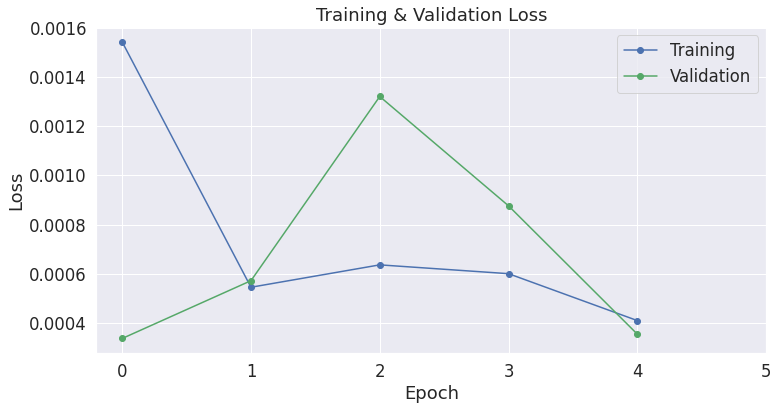

In [55]:
#  Plot loss
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([0, 1, 2, 3, 4, 5])
plt.savefig('/content/drive/MyDrive/Colab Notebooks/NLP/XLNET/file3.png')
plt.show()


####6. Get Predictions

In [56]:
# Cleaning text
test['text_cleaned'] = list(map(lambda x:  preprocess_sentence_english(x),test['text']) )

# Get the lists of sentences and their labels
sentences = test.text_cleaned.values

# input_ids = torch.from_numpy(input_ids)
# attention_masks = torch.tensor(attention_masks)
# labels = torch.tensor(labels)

test_input_ids = tokenize_inputs(sentences, tokenizer, num_embeddings=120)
test_attention_masks = create_attn_masks(test_input_ids)

test["features"] = test_input_ids.tolist()
test["masks"] = test_attention_masks

In [57]:
def generate_predictions(model, df, device="cpu", batch_size=16):
  num_iter = math.ceil(df.shape[0]/batch_size)
  
  pred_probs = []

  #model.to(device)
  #model.eval()
  
  for i in range(num_iter):
    df_subset = df.iloc[i*batch_size:(i+1)*batch_size,:]
    X = df_subset["features"].values.tolist()
    masks = df_subset["masks"].values.tolist()
    X = torch.tensor(X)
    masks = torch.tensor(masks, dtype=torch.long)
    X = X.to(device)
    masks = masks.to(device)
    with torch.no_grad():
      logits = model(input_ids=X, attention_mask=masks)
      logits = logits.sigmoid().detach().cpu().numpy()
#       pred_probs = np.vstack([pred_probs, logits])
      pred_probs.extend(logits.tolist())
        
  return pred_probs

predicted probabilities for real or fake news on the test set.

In [58]:
pred_probs = generate_predictions(model, test, device="cuda", batch_size=16)
# pred_probs
import statistics
statistics.mean(pred_probs)

0.4804657323873718

In [59]:
test['target'] = pred_probs
test['target'] = np.array(test['target'] >= 0.5, dtype='int')
#test[['id', 'target']].to_csv('submission.csv', index=False)

In [62]:
auc_value = roc_auc_score(test['label'], np.asarray(pred_probs) >0.5)
print("auc  on test {}".format(auc_value))
#type(pred_probs)


auc  on test 0.9978233756695014


In [61]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score,precision_recall_curve
from sklearn.metrics import precision_recall_fscore_support
from numpy import trapz
from scipy.integrate import simps
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, roc_auc_score,balanced_accuracy_score
from sklearn.metrics import average_precision_score,cohen_kappa_score

def Evaluate(labels, predictions, p=0.5):
    CM= confusion_matrix(labels, predictions > p)
    TN = CM[0][0]
    FN = CM[1][0]
    TP = CM[1][1]
    FP = CM[0][1]
    print(' (True Negatives): {}'.format(TN))
    print(' (False Negatives):  {}'.format(FN))
    print(' (True Positives): {}'.format(TP))
    print('(False Positives):{}'.format(FP))
    print('Total positive : ', np.sum(CM[1]))
    auc = roc_auc_score(labels, predictions)
    prec=precision_score(labels, predictions>0.5)
    rec=recall_score(labels, predictions>0.5)
     # calculate F1 score
    f1 = f1_score(labels, predictions>p)
    print('auc :{}'.format(auc))
    print('precision :{}'.format(prec))
    print('recall :{}'.format(rec))
    print('f1 :{}'.format(f1))
    # Compute Precision-Recall and plot curve
    precision, recall, thresholds = precision_recall_curve(labels, predictions >0.5)
    #use the trapezoidal rule to calculate the area under the precion-recall curve
    area =  trapz(recall, precision)
   
    #area =  simps(recall, precision)
    print("Area Under Precision Recall  Curve(AP): %0.4f" % area)   #should be same as AP? 
    average_precision = average_precision_score(labels, predictions>0.5)
    print("average precision: %0.4f" % average_precision)
    kappa = cohen_kappa_score(labels, predictions>0.5)
    print('kappa :{}'.format(kappa))
    balanced_accuracy = balanced_accuracy_score(labels, predictions>0.5)
    print('balanced_accuracy :{}'.format(balanced_accuracy))
    
    
   
Evaluate(test['label'], np.asarray(pred_probs) >0.5)

 (True Negatives): 4665
 (False Negatives):  16
 (True Positives): 4296
(False Positives):3
Total positive :  4312
auc :0.9978233756695014
precision :0.9993021632937893
recall :0.9962894248608535
f1 :0.997793519916386
Area Under Precision Recall  Curve(AP): 0.5185
average precision: 0.9974
kappa :0.9957612258946119
balanced_accuracy :0.9978233756695013


Sections of the code used here was obtained thanks to  Jaskaran Singh notebook on kaggle.